Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



[INFO] Running pipeline with yolov8n.pt...

[INFO] Running pipeline with yolov8s.pt...

[INFO] Running pipeline with yolov8m.pt...

[INFO] Running pipeline with yolov8l.pt...

=== YOLO Model Comparison ===
        model  num_detections  mean_depth  min_depth  inference_time_s
0  yolov8n.pt              10    0.445183     0.3543             1.253
1  yolov8s.pt              12    0.325914     0.0281             1.873
2  yolov8m.pt              12    0.443880     0.3554             2.967
3  yolov8l.pt              14    0.390943     0.0284             5.972


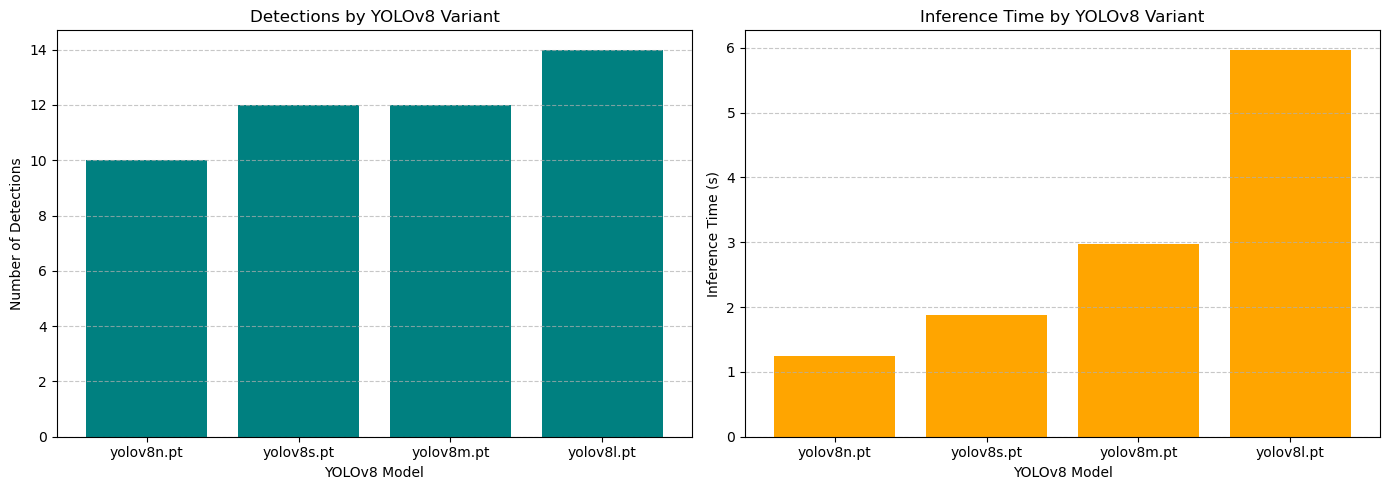

In [1]:
# -------------------- 1. Imports --------------------
import os, time, csv
import cv2
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# -------------------- 2. Config --------------------
IMG_PATH = "./leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_003025_leftImg8bit.png"
OUT_DIR = "./outputs_yolo_versions"
os.makedirs(OUT_DIR, exist_ok=True)

OBSTACLE_CLASS_NAMES = {
    "person", "bicycle", "car", "motorcycle", "bus", "truck", "train",
    "traffic light", "stop sign", "bench"
}

YOLO_VERSIONS = ["yolov8n.pt", "yolov8s.pt", "yolov8m.pt", "yolov8l.pt"]

# -------------------- 3. Helper Functions --------------------
def load_image(path: str) -> np.ndarray:
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Image not found: {path}")
    return cv2.imread(path, cv2.IMREAD_COLOR)

def run_yolo(img_bgr: np.ndarray, weights: str, conf: float = 0.25):
    model = YOLO(weights)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    results = model.predict(source=img_rgb, conf=conf, verbose=False)[0]
    detections = []
    names = model.model.names
    for b in results.boxes:
        cls_id = int(b.cls.item())
        cls_name = names.get(cls_id, str(cls_id))
        if cls_name not in OBSTACLE_CLASS_NAMES:
            continue
        xyxy = b.xyxy.squeeze().cpu().numpy()
        conf_score = float(b.conf.item())
        detections.append({"cls_name": cls_name, "conf": conf_score, "xyxy": xyxy})
    return detections

def load_depth_anything(model_id: str = "depth-anything/Depth-Anything-V2-small-hf"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForDepthEstimation.from_pretrained(model_id).to(device)
    model.eval()
    return processor, model, device

def run_depth_anything(img_bgr: np.ndarray, processor, model, device: str) -> np.ndarray:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    inputs = processor(images=img_rgb, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth.squeeze().cpu().numpy().astype(np.float32)
    d_min, d_max = float(predicted_depth.min()), float(predicted_depth.max())
    return (predicted_depth - d_min) / (d_max - d_min + 1e-8)

def median_depth_in_box(depth_map: np.ndarray, xyxy: np.ndarray) -> float:
    x1, y1, x2, y2 = xyxy.astype(int)
    h, w = depth_map.shape[:2]
    x1, x2 = np.clip([x1, x2], 0, w - 1)
    y1, y2 = np.clip([y1, y2], 0, h - 1)
    if x2 <= x1 or y2 <= y1:
        return float("nan")
    roi = depth_map[y1:y2, x1:x2]
    return float(np.median(roi)) if roi.size > 0 else float("nan")

def direction_from_box(xyxy: np.ndarray, img_w: int) -> str:
    cx = 0.5 * (xyxy[0] + xyxy[2])
    if cx < img_w / 3:
        return "Left"
    elif cx > 2 * img_w / 3:
        return "Right"
    return "Center"

def annotate_and_save(img_bgr, detections, depth_map, out_image_path, out_csv_path):
    h, w = img_bgr.shape[:2]
    vis = img_bgr.copy()
    with open(out_csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["class", "confidence", "distance_rel", "direction", "x1", "y1", "x2", "y2"])
        detections_sorted = sorted(detections, key=lambda d: median_depth_in_box(depth_map, d["xyxy"]))
        for det in detections_sorted:
            dist_rel = median_depth_in_box(depth_map, det["xyxy"])
            direction = direction_from_box(det["xyxy"], w)
            x1, y1, x2, y2 = det["xyxy"].astype(int)
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{det['cls_name']} {det['conf']:.2f} | rel={dist_rel:.2f} | {direction}"
            cv2.putText(vis, label, (x1, max(0, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            writer.writerow([det["cls_name"], f"{det['conf']:.4f}", f"{dist_rel:.4f}", direction, x1, y1, x2, y2])
    cv2.imwrite(out_image_path, vis)
    return vis

# -------------------- 4. Main Experiment: Multiple YOLO Versions --------------------
img_bgr = load_image(IMG_PATH)
processor, depth_model, device = load_depth_anything()
depth_rel = run_depth_anything(img_bgr, processor, depth_model, device)

results_summary = []

for weights in YOLO_VERSIONS:
    print(f"\n[INFO] Running pipeline with {weights}...")
    start = time.time()

    detections = run_yolo(img_bgr, weights=weights, conf=0.25)
    out_img = os.path.join(OUT_DIR, f"annotated_{weights.replace('.pt', '')}.png")
    out_csv = os.path.join(OUT_DIR, f"detections_{weights.replace('.pt', '')}.csv")
    annotate_and_save(img_bgr, detections, depth_rel, out_img, out_csv)

    df = pd.read_csv(out_csv)
    elapsed = time.time() - start

    results_summary.append({
        "model": weights,
        "num_detections": len(df),
        "mean_depth": df["distance_rel"].mean(),
        "min_depth": df["distance_rel"].min(),
        "inference_time_s": round(elapsed, 3)
    })

# -------------------- 5. Summary Table --------------------
summary_df = pd.DataFrame(results_summary)
print("\n=== YOLO Model Comparison ===")
print(summary_df)

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Subplot 1: Number of Detections
axes[0].bar(summary_df["model"], summary_df["num_detections"], color="teal")
axes[0].set_ylabel("Number of Detections")
axes[0].set_xlabel("YOLOv8 Model")
axes[0].set_title("Detections by YOLOv8 Variant")
axes[0].grid(axis="y", linestyle='--', alpha=0.7)

# Subplot 2: Inference Time
axes[1].bar(summary_df["model"], summary_df["inference_time_s"], color="orange")
axes[1].set_ylabel("Inference Time (s)")
axes[1].set_xlabel("YOLOv8 Model")
axes[1].set_title("Inference Time by YOLOv8 Variant")
axes[1].grid(axis="y", linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
